# Inspection of linear models

In this notebook, we will discuss how to inspect attribute exposed by linear models after fitting and some of the caveats to have in mind when trying to interpret them.

To illustrate this example, we will use the penguins dataset.

In [45]:
import pandas as pd

data = pd.read_csv("../datasets/penguins.csv")
data.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


From the dataset, we will select a subset of features that we can easily get insight without to be an expert.

In [46]:
data = data[[
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
    "Body Mass (g)",
    "Sex",
]].dropna(axis="index")

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Culmen Length (mm)   334 non-null    float64
 1   Culmen Depth (mm)    334 non-null    float64
 2   Flipper Length (mm)  334 non-null    float64
 3   Body Mass (g)        334 non-null    float64
 4   Sex                  334 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.7+ KB


For our problem, we will try to predict the body mass of a penguins given other measurement and whether or not a penguin is a male or female.

In [48]:
target_name = "Body Mass (g)"
X, y = data.drop(columns=target_name), data[target_name]

In [49]:
import sklearn
sklearn.set_config(display="diagram")

In this regard, the "Sex" of the penguin is a categorical variable and we will need to encode it. We will use a one-hot encoder for such processing.

In [50]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), selector(dtype_include=object)),
    remainder="passthrough",
    verbose_feature_names_out=False,  # to be less verbose in the feature names
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x140a00ee0>)],
                  verbose_feature_names_out=False)

We will use a `RidgeCV` model regarding the modeling between the features and the target.

In [51]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 3, num=100)
model = make_pipeline(
    preprocessor, RidgeCV(alphas=alphas)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x140a00ee0>)],
                                   verbose_feature_names_out=False)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.5199110...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])))])

## Evaluate your model

Before to do anything, be aware that any "interpretation" will be done on the model trained and not the data generative process. If your model preforms poorly, you can still inspect it. However, the interpretation will not be linked to the original dataset since the model did not succeed to model properly these data.

Thus, an important step is to have an idea of the model accuracy. Let's perform a cross-validation to have an idea on the statistical model performance.

In [52]:
import pandas as pd
from sklearn.model_selection import cross_validate, RepeatedKFold

cv = RepeatedKFold(n_repeats=30, n_splits=5, random_state=0)
cv_results = cross_validate(
    model, X, y, cv=cv,
    return_estimator=True, return_train_score=True,
    n_jobs=-1,
)
cv_results = pd.DataFrame(cv_results)

In [53]:
import seaborn as sns
sns.set_context("poster")

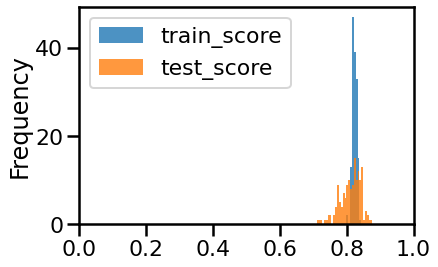

In [54]:
ax = cv_results[["train_score", "test_score"]].plot.hist(bins=30, alpha=0.8)
ax.set_xlim([0, 1])
_ = ax.legend(loc="upper left")

Good news, it seems that we get a reasonable score. Our model is capable of modeling the provided dataset.

Since we stored the models trained and tested on each cross-validation fold, we can now check their coefficients.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Make a box plot of the coefficients the different models.
</div>

In [55]:
preprocessor.fit(X)
coef = [estimator[-1].coef_ for estimator in cv_results["estimator"]]
coef = pd.DataFrame(coef, columns=preprocessor.get_feature_names_out(X.columns))
coef

,Sex_.,Sex_FEMALE,Sex_MALE,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm)
0,-16.570055,-250.699252,267.269307,1.593015,-95.175366,37.153624
1,-34.568832,-261.405821,295.974653,-1.854623,-81.062923,39.942578
2,-267.465419,267.465419,-4.700545,-83.863770,39.646687,NaN
3,-35.992655,-243.504190,279.496845,-5.546509,-81.147646,39.706215
4,-24.531895,-247.502152,272.034047,-0.695990,-78.036444,39.030345
...,...,...,...,...,...,...
145,-22.761328,-244.243903,267.005230,-1.680710,-77.319154,39.079570
146,-263.823979,263.823979,-1.810627,-80.766690,38.002227,NaN
147,-25.191059,-275.141941,300.333000,-1.175989,-81.126929,37.732211
148,-43.844236,-219.627707,263.471943,-5.277151,-88.164627,41.106379


By storing those during the cross-validation, we will have an information regarding the variability of these coefficients.

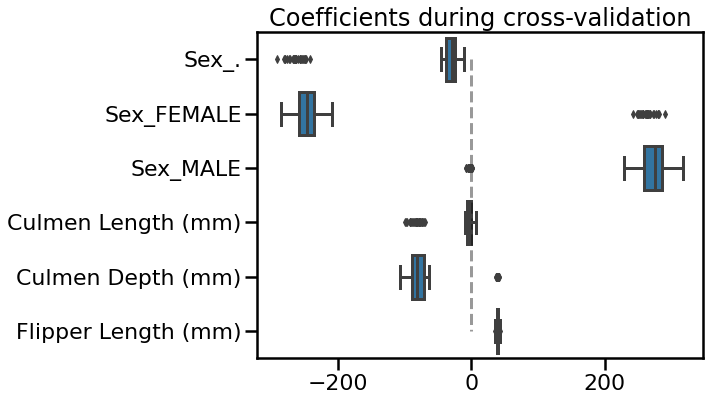

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zer

In [58]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(8, 6))
ax = sns.boxplot(data=coef, orient='h', ax=ax, color="tab:blue")
ax.set_title("Coefficients during cross-validation")
_ = ax.vlines(0, 0, 5, linestyle="--", alpha=0.4, color="black")

## Sign of the coefficients

A positive coefficient tell us that when their is an increase of the feature value, then their is an increase of the target value.

<div class="alert alert-success">
    <p><b>QUESTION</b>:</p>
    Why is the coefficient associated to <tt>Culmen Depth (mm)</tt> negative? Does the body mass of the penguins decreases with the depth of their culmen?
</div>

The coefficients of a linear model are a conditional association: they quantify the variation of a the output (the body mass) when the given feature is varied, keeping all other features constant. We should not interpret them as a marginal association, characterizing the link between the two quantities ignoring all the rest.

## Effect of correlated features

In the above plot, we can as well think that our current encoding will create two features that are exactly anticorrelated: male and female penguins. This will have an impact on the coefficient as well. You might detect correlated feature by looking at the variation. Indeed, since only one of the feature is required, the model could use one of the two features to model the problem and depending of the CV fold, it would change.

Let's see what would be the effect on removing one of the sex category. In addition, we also have an issue with the `"."` category.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Remove the sample containg the category <tt>"."</tt>.</li>
        <li>Change the preprocessor to drop one of the <tt>"Sex"</tt> column in the <tt>OneHotEncoder</tt>.</li>
        <li>Plot the coefficients.</li>
    </ul>
    What is the effect on the coefficients?
</div>

In [69]:
(data["Sex"] == ".").value_counts()

False    333
True       1
Name: Sex, dtype: int64

We see that we have 1 sample. We will remove it from the database.

In [70]:
data = data[data["Sex"] != "."]
X, y = data.drop(columns=target_name), data[target_name]

Now, we will modify our preprocessor such that we drop one of the column.

In [71]:
preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"), selector(dtype_include=object)),
    remainder="passthrough",
    verbose_feature_names_out=False,  # to be less verbose in the feature names
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x142b1e4f0>)],
                  verbose_feature_names_out=False)

In [72]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 3, num=100)
model = make_pipeline(
    preprocessor, RidgeCV(alphas=alphas)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x142b1e4f0>)],
                                   verbose_feature_names_out=False)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.14975700e-03, 1.32194...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])))])

Let's have first a quick look that our overall results did not drop.

In [73]:
cv_results = cross_validate(
    model, X, y, cv=cv,
    return_estimator=True, return_train_score=True,
    n_jobs=-1,
)
cv_results = pd.DataFrame(cv_results)

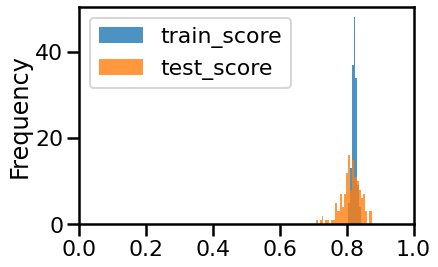

In [74]:
ax = cv_results[["train_score", "test_score"]].plot.hist(bins=30, alpha=0.8)
ax.set_xlim([0, 1])
_ = ax.legend(loc="upper left")

Let's inspect our coefficients now.

In [75]:
preprocessor.fit(X)
coef = [estimator[-1].coef_ for estimator in cv_results["estimator"]]
coef = pd.DataFrame(coef, columns=preprocessor.get_feature_names_out(X.columns))

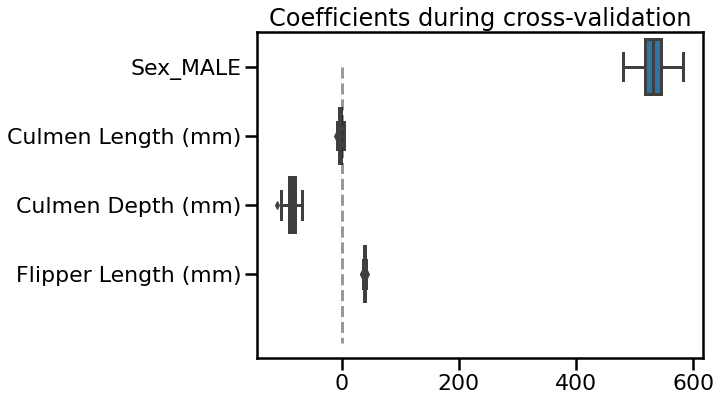

In [76]:
_, ax = plt.subplots(figsize=(8, 6))
ax = sns.boxplot(data=coef, orient='h', ax=ax, color="tab:blue")
ax.set_title("Coefficients during cross-validation")
_ = ax.vlines(0, 0, len(X.columns), linestyle="--", alpha=0.4, color="black")

We observe that we have much less coefficients variation. In addition, we observe that the correlated features has an impact on all features.

## Scale of coefficients

In [77]:
coef.mean()

Sex_MALE               531.769871
Culmen Length (mm)      -2.277055
Culmen Depth (mm)      -84.237616
Flipper Length (mm)     39.055484
dtype: float64

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zer

The value of the coefficients are expressed in their original unit. The flipper length coefficient value is expressed in g per mm. Increasing the flipper length of 1 mm will increase the body mass of 39 g. However, if features are not in the same unit, we cannot compare betweem them. One need to rescale the coefficients to have a relative comparison between them.

Text(0.5, 1.0, 'Features std. dev.')

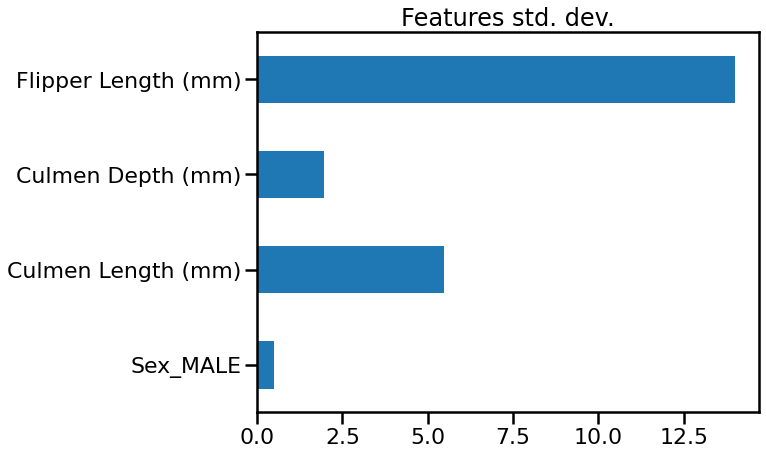

In [81]:
X_transformed = pd.DataFrame(
    preprocessor.fit_transform(X),
    columns=preprocessor.get_feature_names_out(X.columns),
)

X_transformed.std(axis=0).plot(kind='barh', figsize=(9, 7))
plt.title('Features std. dev.')

So the right way to do so is to rescale the data during `fit`.

In [82]:
from sklearn.preprocessing import StandardScaler

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"), selector(dtype_include=object)),
    (StandardScaler(), selector(dtype_exclude=object)),
    verbose_feature_names_out=False,  # to be less verbose in the feature names
)
preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14416fbb0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x14416fd90>)],
                  verbose_feature_names_out=False)

In [83]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-3, 3, num=100)
model = make_pipeline(
    preprocessor, RidgeCV(alphas=alphas)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14416fbb0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14416fd90>)],
                                   verbose_featur...
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])))])

In [84]:
cv_results = cross_validate(
    model, X, y, cv=cv,
    return_estimator=True, return_train_score=True,
    n_jobs=-1,
)
cv_results = pd.DataFrame(cv_results)

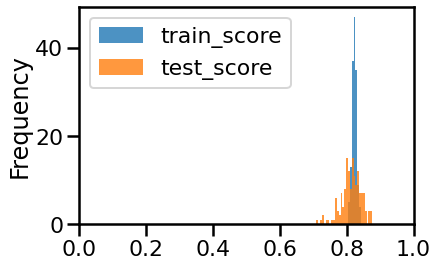

In [85]:
ax = cv_results[["train_score", "test_score"]].plot.hist(bins=30, alpha=0.8)
ax.set_xlim([0, 1])
_ = ax.legend(loc="upper left")

Let's inspect our coefficients now.

In [86]:
preprocessor.fit(X)
coef = [estimator[-1].coef_ for estimator in cv_results["estimator"]]
coef = pd.DataFrame(coef, columns=preprocessor.get_feature_names_out(X.columns))

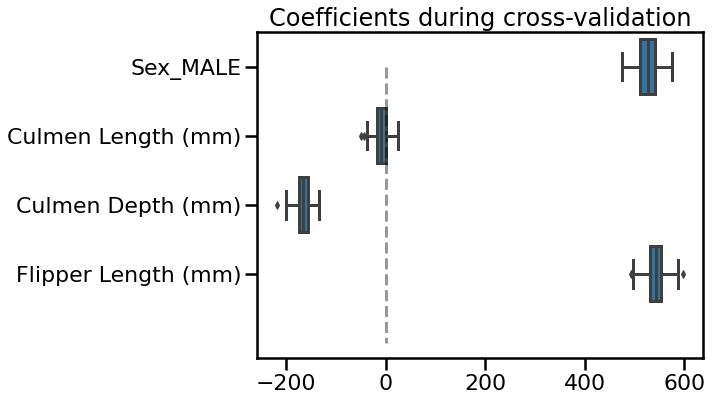

In [87]:
_, ax = plt.subplots(figsize=(8, 6))
ax = sns.boxplot(data=coef, orient='h', ax=ax, color="tab:blue")
ax.set_title("Coefficients during cross-validation")
_ = ax.vlines(0, 0, len(X.columns), linestyle="--", alpha=0.4, color="black")

Now that the coefficients have been scaled, we can safely compare them.

## Impact of the regularization on the coefficients

We already mentioned this specificity earlier. One should check the variation of the regularization parameter in the cross-valdiation as well:

In [93]:
alpha = pd.Series(
    [estimator[-1].alpha_ for estimator in cv_results["estimator"]]
)
alpha

0      1.072267
1      0.932603
2      1.629751
3      1.417474
4      1.417474
         ...   
145    1.232847
146    1.232847
147    1.232847
148    1.417474
149    0.932603
Length: 150, dtype: float64

In [94]:
alpha.mean(), alpha.std()

(1.259575681745631, 0.20133516097773246)

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zero encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1729: RuntimeWarning: divide by zer

Here, we see that we have a little variation and we have a single type of models that work well. However, since regularization will shrink coefficients zeros, you need to ensure to look at this specific aspect. Let's have a look at forcing the regualarization strength in the ridge model.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Run two pipelines by changing <tt>alpha</tt> from 1 to 100,000.</li>
        <li>Plot the coefficients.</li>
    </ul>
    What is the effect of the regularization parameter on the coefficients.
</div>

In [95]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

model = make_pipeline(
    preprocessor, Ridge(alpha=1)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14416fbb0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14416fd90>)],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(alpha=1))])

In [96]:
cv_results = cross_validate(
    model, X, y, cv=cv,
    return_estimator=True, return_train_score=True,
    n_jobs=-1,
)
cv_results = pd.DataFrame(cv_results)

Let's inspect our coefficients now.

In [97]:
preprocessor.fit(X)
coef = [estimator[-1].coef_ for estimator in cv_results["estimator"]]
coef = pd.DataFrame(coef, columns=preprocessor.get_feature_names_out(X.columns))

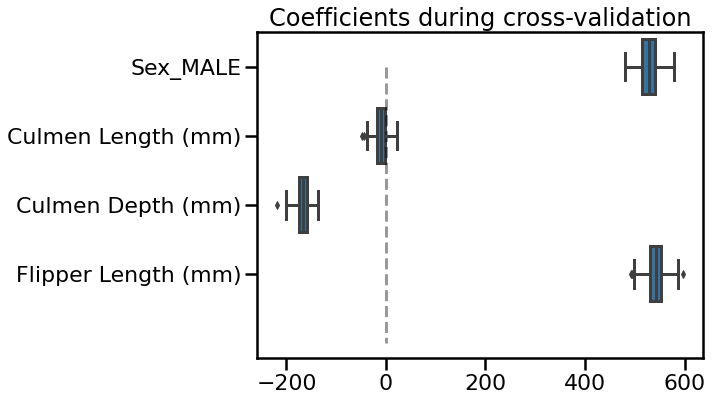

In [98]:
_, ax = plt.subplots(figsize=(8, 6))
ax = sns.boxplot(data=coef, orient='h', ax=ax, color="tab:blue")
ax.set_title("Coefficients during cross-validation")
_ = ax.vlines(0, 0, len(X.columns), linestyle="--", alpha=0.4, color="black")

Now, let increase the strength to 100,000.

In [103]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

model = make_pipeline(
    preprocessor, Ridge(alpha=100_000)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14416fbb0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x14416fd90>)],
                                   verbose_feature_names_out=False)),
                ('ridge', Ridge(alpha=100000))])

In [104]:
cv_results = cross_validate(
    model, X, y, cv=cv,
    return_estimator=True, return_train_score=True,
    n_jobs=-1,
)
cv_results = pd.DataFrame(cv_results)

Let's inspect our coefficients now.

In [105]:
preprocessor.fit(X)
coef = [estimator[-1].coef_ for estimator in cv_results["estimator"]]
coef = pd.DataFrame(coef, columns=preprocessor.get_feature_names_out(X.columns))

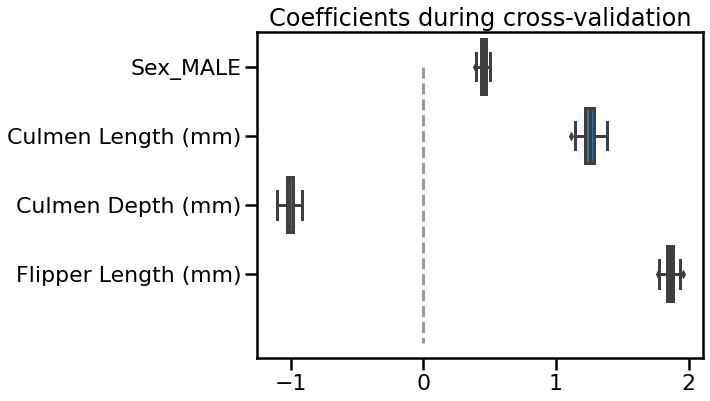

In [106]:
_, ax = plt.subplots(figsize=(8, 6))
ax = sns.boxplot(data=coef, orient='h', ax=ax, color="tab:blue")
ax.set_title("Coefficients during cross-validation")
_ = ax.vlines(0, 0, len(X.columns), linestyle="--", alpha=0.4, color="black")

We observe that the coefficients are shrinked.